In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import pandas_datareader as web
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [13]:
start = '1971-01-01'
end = datetime.today().strftime('%Y-%m-%d')
#주식 VTI : Vanguard Total Stock Market ETF  30%
#장기채권(제로쿠폰) EDV : Vanguard Extened Duration Treasury Index Fund ETF      40%
#중기채권 IEI : iShares 3-7 Year Treasury Bond ETF 15%
#원자재(금) GLD : SPDR Gold Trust 7.5%
#원자재 BCI : Aberdeen Standard Bloomberg All Commodity  7.5%

asset = ['VTI', 'EDV', 'IEI', 'GLD', 'GSG']
ratio = [3, 4, 1.5, 0.75, 0.75]
leverage = [1, 1, 1, 1, 1]

initial_balance = 1000
rebalancing_interval = 12 # 월 단위

In [5]:
# 첫 거래일 계산
for i in range(len(asset)):
  if datetime.strptime(start, '%Y-%m-%d') <= web.get_data_yahoo(asset[i], start, end).index[0]:
    start = web.get_data_yahoo(asset[i], start, end).index[0].strftime('%Y-%m-%d')

print(start)

2008-01-29


In [6]:
# 지수 데이터 생성
asset_data = []
for i in range(len(asset)):
  asset_data.append(web.get_data_yahoo(asset[i], start, end))

In [26]:
# 날짜 리스트 생성
date = asset_data[0].index
print(date)

DatetimeIndex(['2008-01-29', '2008-01-30', '2008-01-31', '2008-02-01',
               '2008-02-04', '2008-02-05', '2008-02-06', '2008-02-07',
               '2008-02-08', '2008-02-11',
               ...
               '2020-11-09', '2020-11-10', '2020-11-11', '2020-11-12',
               '2020-11-13', '2020-11-16', '2020-11-17', '2020-11-18',
               '2020-11-19', '2020-11-20'],
              dtype='datetime64[ns]', name='Date', length=3229, freq=None)


In [27]:
# 가격, 등락률 데이터 생성
asset_change, asset_price = [], []
for i in range(len(asset)):
  # 가격 데이터
  price = asset_data[i]['Adj Close']
  asset_price.append(price.to_list())

  # 등락률 데이터
  change = np.multiply(price.pct_change().to_list(), [100 * leverage[i]])
  asset_change.append(change)

In [28]:
# 백테스트
def backtest():
  # 첫 거래일
  asset_balance = []
  for i in range(len(asset)):
    balance = [initial_balance * ratio[i] / sum(ratio)]
    asset_balance.append(balance)
  
  total_balance = [initial_balance]
  next_rebalancing = [date[0] + relativedelta(months=rebalancing_interval)]

  # 이후 거래일
  for i in range(1, len(date)):
    total_balance_tmp = 0

    if date[i] >= next_rebalancing[i-1]: # 리밸런싱하는 날
      # 다음 리밸런싱 날짜 추가해줌
      next_rebalancing.append(next_rebalancing[i-1] + relativedelta(months=rebalancing_interval))
      for j in range(len(asset)):
        balance = total_balance[i-1] * ratio[j] / sum(ratio) * (1 + asset_change[j][i] / 100)
        asset_balance[j].append(balance)
        total_balance_tmp += asset_balance[j][i]
    else:
      # 그냥 이전 리밸런싱 날짜랑 동일하게
      next_rebalancing.append(next_rebalancing[i-1])
      for j in range(len(asset)):
        try:
          asset_balance[j].append(asset_balance[j][i-1] * (1 + asset_change[j][i] / 100))
        except:
          asset_balance[j].append(asset_balance[j][i-1])
        total_balance_tmp += asset_balance[j][i]

    total_balance.append(total_balance_tmp)

  backtest_df = pd.DataFrame()
  backtest_df['Date'] = date
  backtest_df.set_index('Date', inplace=True)
  backtest_df['Total'] = total_balance
  for i in range(len(asset)):
    backtest_df[asset[i]] = asset_balance[i]

  print('Portfolio Backtest Complete')

  return backtest_df

In [29]:
backtest_df = backtest()
backtest_df

Portfolio Backtest Complete


,Total,VTI,EDV,IEI,GLD,GSG
Date,,,,,,
2008-01-29,1000.000000,300.000000,400.000000,150.000000,75.000000,75.000000
2008-01-30,989.591338,297.283087,391.378999,150.180490,75.748762,75.000000
2008-01-31,1004.571203,303.318256,400.367759,150.693763,75.205705,74.985719
2008-02-01,1008.383380,308.217614,402.043045,151.017812,73.518922,73.585987
2008-02-04,1001.170441,304.565424,398.447391,150.572840,73.313217,74.271570
...,...,...,...,...,...,...
2020-11-16,2714.927688,836.634715,1129.400469,389.254052,221.676805,137.961646
2020-11-17,2721.589606,834.741068,1137.892757,389.635327,220.863435,138.457019
2020-11-18,2717.451996,825.903982,1143.601867,389.518022,219.599577,138.828546


In [30]:
def balance_result(balance):
  change = [0]
  cum_return = [0]
  prev_high = [0]
  prev_high_tmp = 0
  drawdown = [0]
  mdd = [0]
  mdd_temp = 0
  CAGR = [0]
  stdev = [0]
  sharpe = [0]

  time_period = (date[-1] - date[0]).days / 365 

  for i in range(1, len(date)):
    change.append((balance[i] / balance[i-1] - 1) * 100)

    cum_return.append((balance[i] / balance[0] - 1) * 100)

    if prev_high_tmp < cum_return[i]:
      prev_high_tmp = cum_return[i]
    else:
      prev_high_tmp = prev_high_tmp
    prev_high.append(prev_high_tmp)

    CAGR.append(((balance[i] / balance[0]) ** (1 / float(time_period)) - 1) * 100)

    drawdown.append(((cum_return[i] + 100) / (prev_high[i] + 100) - 1) * 100)

    if mdd_temp > drawdown[i]:
      mdd_temp = drawdown[i]
    else:
      mdd_temp = mdd_temp
    mdd.append(mdd_temp)

    stdev.append(np.std(change))
    if stdev[i] != 0:
      sharpe.append(np.sqrt(252) * np.mean(change) / np.std(change))
    else:
      sharpe.append(0)

  return change, cum_return, prev_high, CAGR, drawdown, mdd, stdev, sharpe

In [31]:
def backtest_result(data):
  result_df = pd.DataFrame()
  result_df['Date'] = date
  result_df.set_index('Date', inplace=True)
  label = ['Change', 'Cum Return', 'Prev High', 'CAGR', 'Drawdown', 'MDD', 'St Dev', 'Sharpe']
  
  result = dict()
  for i in data.columns:
    result[i] = balance_result(data[i].to_list())
    result_df[f'{i} Balance'] = data[i].to_list()
    print(f'{i} Complete')
  for j in range(len(label)):
    for i in data.columns:
      print(i)
      print(f'{i} {label[j]}')
      print(result[i])
      result_df[f'{i} {label[j]}'] = result[i][j]
  
  return result_df

In [32]:
backtest_result_df = backtest_result(backtest_df)
backtest_result_df

Total Complete
VTI Complete
EDV Complete
IEI Complete
GLD Complete


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



([0, 0.9983499917512129, -0.7169194549399793, -2.242891704085337, -0.2797985498258382, -1.593712899285582, 1.4484450714485675, 1.011806134633808, 1.2799126827031992, 0.36263937478537844, -2.189860899926044, 0.12313960382492883, 0.3018745926838262, -0.6242309266623058, 2.7257434252206725, 1.8126184751308339, 0.010727302080248968, 0.15013339372487167, -0.6960076347863775, 1.0459362120408988, 1.141820195579868, 1.2766396919778877, 0.19793983293541206, 1.102097686868797, -2.118467301366811, 2.668628816330454, -1.248466235635548, -0.42487426125323857, -0.22894536340182237, 0.12516440361922676, 1.0626151632053826, 1.3709866739230137, 0.3762484852152248, 0.4660106258120855, -2.692344679079983, -3.585491279246289, -3.3641414688503124, 0.21131665473592687, 2.918984381079537, 1.1538872598824357, -0.36247756526995856, -1.690564783364279, -1.5999060026679723, -3.926560013231817, 2.7745751966154586, 0.1680312888087787, 0.9282060479206544, 1.0193885528479996, -0.8994183517528342, 2.1472080511013125,

,Total Balance,VTI Balance,EDV Balance,IEI Balance,GLD Balance,GSG Balance,Total Change,VTI Change,EDV Change,IEI Change,GLD Change,GSG Change,Total Cum Return,VTI Cum Return,EDV Cum Return,IEI Cum Return,GLD Cum Return,GSG Cum Return,Total Prev High,VTI Prev High,EDV Prev High,IEI Prev High,GLD Prev High,GSG Prev High,Total CAGR,VTI CAGR,EDV CAGR,IEI CAGR,GLD CAGR,GSG CAGR,Total Drawdown,VTI Drawdown,EDV Drawdown,IEI Drawdown,GLD Drawdown,GSG Drawdown,Total MDD,VTI MDD,EDV MDD,IEI MDD,GLD MDD,GSG MDD,Total St Dev,VTI St Dev,EDV St Dev,IEI St Dev,GLD St Dev,GSG St Dev,Total Sharpe,VTI Sharpe,EDV Sharpe,IEI Sharpe,GLD Sharpe,GSG Sharpe
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-01-29,1000.000000,300.000000,400.000000,150.000000,75.000000,75.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2008-01-30,989.591338,297.283087,391.378999,150.180490,75.748762,75.000000,-1.040866,-0.905638,-2.155250,0.120326,0.998350,0.000000,-1.040866,-0.905638,-2.155250,0.120326,0.998350,0.000000,0.000000,0.000000,0.000000,0.120326,0.998350,0.000000,-0.081588,-0.070944,-0.169821,0.009381,0.077523,0.000000,-1.040866,-0.905638,-2.155250,0.000000,0.000000,0.000000,-1.040866,-0.905638,-2.155250,0.000000,0.000000,0.000000,0.520433,0.452819,1.077625,0.060163,0.499175,0.000000,-15.874508,-15.874508,-15.874508,15.874508,15.874508,0.000000
2008-01-31,1004.571203,303.318256,400.367759,150.693763,75.205705,74.985719,1.513743,2.030109,2.296689,0.341771,-0.716919,-0.019041,0.457120,1.106085,0.091940,0.462509,0.274273,-0.019041,0.457120,1.106085,0.091940,0.462509,0.998350,0.000000,0.035584,0.085847,0.007169,0.036003,0.021369,-0.001485,0.000000,0.000000,0.000000,0.000000,-0.716919,-0.019041,-1.040866,-0.905638,-2.155250,0.000000,-0.716919,-0.019041,1.048854,1.227469,1.817802,0.141548,0.703391,0.008976,2.385677,4.847486,0.411720,17.274581,2.117160,-11.224972
2008-02-01,1008.383380,308.217614,402.043045,151.017812,73.518922,73.585987,0.379483,1.615253,0.418437,0.215038,-2.242892,-1.866666,0.838338,2.739205,0.510761,0.678541,-1.974770,-1.885351,0.838338,2.739205,0.510761,0.678541,0.998350,0.000000,0.065146,0.211028,0.039750,0.052767,-0.155469,-0.148367,0.000000,0.000000,0.000000,0.000000,-2.943731,-1.885351,-1.040866,-0.905638,-2.155250,0.000000,-2.943731,-1.885351,0.913400,1.191012,1.582451,0.125399,1.181038,0.805579,3.703412,9.129160,1.404112,21.430062,-6.591071,-9.289795
2008-02-04,1001.170441,304.565424,398.447391,150.572840,73.313217,74.271570,-0.715297,-1.184939,-0.894346,-0.294649,-0.279799,0.931676,0.117044,1.521808,-0.388152,0.381893,-2.249043,-0.971240,0.838338,2.739205,0.510761,0.678541,0.998350,0.000000,0.009125,0.117889,-0.030333,0.029738,-0.177289,-0.076106,-0.715297,-1.184939,-0.894346,-0.294649,-3.215293,-0.971240,-1.040866,-1.184939,-2.155250,-0.294649,-3.215293,-1.885351,0.897410,1.301628,1.474616,0.216835,1.059705,0.913322,0.484905,3.792398,-0.720126,5.600386,-6.714865,-3.316411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-16,2714.927688,836.634715,1129.400469,389.254052,221.676805,137.961646,0.300777,1.221902,-0.308665,-0.015060,-0.005650,1.180746,171.492769,178.878238,182.350117,159.502702,195.569074,83.948861,178.296922,178.878238,213.758202,161.645103,223.499235,146.365973,8.102731,8.329305,8.433911,7.722502,8.821629,4.869337,-2.444926,0.000000,-10.010283,-0.818820,-8.633764,-25.335119,-19.494456,-47.252081,-54.807758,-14.357261,-31.731272,-66.352446,0.614009,1.7

In [33]:
def periodic_result(data, mode):
  return_df = pd.DataFrame()

  for label in data.columns:
    return_points = []
    returns = []
    start_balance = []
    end_balance = []
    start = data[label].to_list()[0]
    
    if mode == 'annual':
      for i in range(1, len(date)):
        if date[i].year != date[i-1].year:
          return_points.append(date[i-1].year)
          returns.append((data[label].to_list()[i-1] / start - 1) * 100)
          start_balance.append(start)
          end_balance.append(data[label].to_list()[i-1])
          start = data[label].to_list()[i]
        elif date[i] == date[-1]: # 마지막 거래일
          return_points.append(date[i].year)
          returns.append((data[label].to_list()[i] / start - 1) * 100)
          start_balance.append(start)
          end_balance.append(data[label].to_list()[i-1])
      return_df[f'{label} {mode.capitalize()} Return'] = returns
      
    elif mode == 'monthly':
      for i in range(1, len(date)):
        if date[i].month != date[i-1].month:
          return_points.append(date[i-1].strftime('%Y-%m'))
          returns.append((data[label].to_list()[i-1] / start - 1) * 100)
          start_balance.append(start)
          end_balance.append(data[label].to_list()[i-1])
          start = data[label].to_list()[i]
        elif date[i] == date[-1]: # 마지막 거래일
          return_points.append(date[i].strftime('%Y-%m'))
          returns.append((data[label].to_list()[i] / start - 1) * 100)
          start_balance.append(start)
          end_balance.append(data[label].to_list()[i-1])
      return_df[f'{label} {mode.capitalize()} Return'] = returns

  return_df[f'Return {mode.capitalize()}'] = return_points
  return_df.set_index(f'Return {mode.capitalize()}', inplace=True)

  print(f'{mode.capitalize()} Result Complete')

  return return_df

In [34]:
monthly_return_df = periodic_result(backtest_df, 'monthly')
monthly_return_df

Monthly Result Complete


,Total Monthly Return,VTI Monthly Return,EDV Monthly Return,IEI Monthly Return,GLD Monthly Return,GSG Monthly Return
Return Monthly,,,,,,
2008-01,0.457120,1.106085,0.091940,0.462509,0.274273,-0.019041
2008-02,-1.055360,-4.046250,-3.892282,1.335600,7.644098,13.373446
2008-03,0.960522,-0.542657,4.411884,0.921397,-7.023853,-2.246998
2008-04,0.032467,1.424663,-2.413969,-1.515988,-0.241767,10.056254
2008-05,-0.687098,0.250308,-4.603316,-1.033864,4.119537,10.352678
...,...,...,...,...,...,...
2020-07,5.368053,5.132117,6.359013,0.479663,11.289160,2.870815
2020-08,-0.889132,6.181115,-5.943150,-0.261320,-0.436327,3.591163
2020-09,-2.122249,-4.384356,-0.558598,-0.007491,-4.285333,-4.698579


In [35]:
annual_return_df = periodic_result(backtest_df, 'annual')
annual_return_df

Annual Result Complete


,Total Annual Return,VTI Annual Return,EDV Annual Return,IEI Annual Return,GLD Annual Return,GSG Annual Return
Return Annual,,,,,,
2008,9.774238,-32.102451,54.212022,10.098436,-5.079544,-45.515137
2009,-3.412833,88.597927,-47.620758,-9.892680,28.851253,113.144503
2010,11.542384,-8.877824,47.860969,7.746519,5.945363,-5.236257
2011,25.717083,-8.554556,71.707066,14.443721,0.488920,-8.090913
2012,5.985714,39.519918,-15.013885,20.804047,2.315265,23.767561
2013,-1.033192,18.017338,-15.491776,2.892627,-20.675828,4.746589
2014,17.874817,-7.128855,59.226156,4.189335,28.254927,-26.265346
2015,-4.519303,8.184397,-24.198222,18.301786,6.025041,35.816926
2016,6.203106,10.899002,1.218538,-8.874483,12.952221,44.312925


In [36]:
def portfolio_returns(backtest_result_df):
  portfolio = pd.DataFrame(columns=['Detail', 'Initial Balance', 'Final Balance', 'CAGR', 'MDD', 'St Dev', 'Sharpe Ratio'])

  detail = ''
  for i in range(len(asset)):
    name = asset[i]
    percentage = int(ratio[i] / sum(ratio) * 100)

    detail += f'{name} ({percentage}%, {leverage[i]}x) '

  portfolio.loc[0] = [
    detail,
    backtest_result_df['Total Balance'][0],
    backtest_result_df['Total Balance'][-1],
    str(round(backtest_result_df['Total CAGR'][-1], 2)) + '%',
    str(round(backtest_result_df['Total MDD'][-1], 2)) + '%',
    round(backtest_result_df['Total St Dev'][-1], 2),
    round(backtest_result_df['Total Sharpe'][-1], 2)
  ]
  
  return portfolio

In [37]:
portfolio = portfolio_returns(backtest_result_df)
portfolio

,Detail,Initial Balance,Final Balance,CAGR,MDD,St Dev,Sharpe Ratio
0,"VTI (30%, 1x) EDV (40%, 1x) IEI (15%, 1x) GLD ...",1000.0,2740.679501,8.18%,-19.49%,0.61,0.86


In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

def line_plotting(returns, title, return_type):
  plt.plot(date, backtest_result_df.loc[:, f'Total {returns}'])
  plt.title(title)
  plt.yscale(return_type)
  plt.show()

def bar_plotting(period, title):
  if period == 'annual':
    plt.bar(annual_return_df.index, annual_return_df.loc[:, 'Total Annual Return'])
  elif period == 'monthly':
    plt.bar(monthly_return_df.index, monthly_return_df.loc[:, 'Total Monthly Return'])
  plt.show()

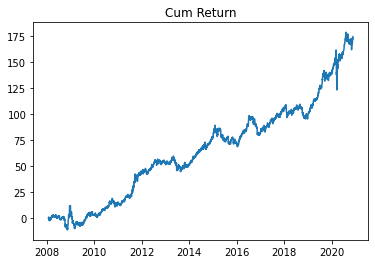

In [40]:
line_plotting('Cum Return', 'Cum Return', 'linear')

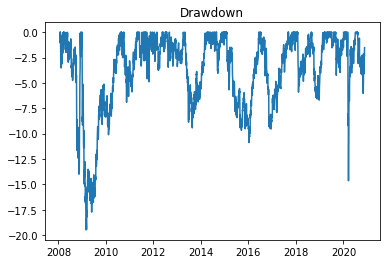

In [41]:
line_plotting('Drawdown', 'Drawdown', 'linear')

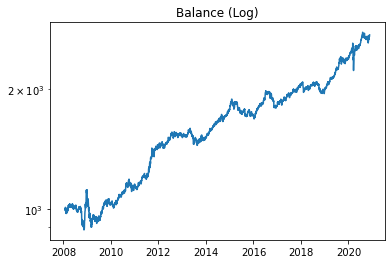

In [42]:
line_plotting('Balance', 'Balance (Log)', 'log')

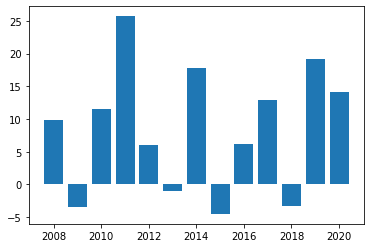

In [43]:
bar_plotting('annual', 'Annual Return')

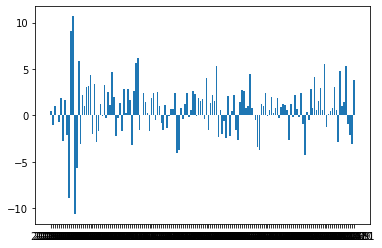

In [44]:
bar_plotting('monthly', 'Monthly Return')